### This notebook analyses the IWP retreived using QRNN. Uses test data (simulations)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from torch.utils.data import DataLoader, random_split
from iwc2tb.GMI.gmiData import gmiData
from iwc2tb.GMI.GOES import GOES
import os
from mpl_toolkits.basemap import Basemap, cm
import numpy.ma as ma
from iwc2tb.common.hist2d import hist2d
from iwc2tb.common.plot_locations_map import plot_locations_map
import matplotlib.colors as colors
from matplotlib import cm
import scipy
from matplotlib import ticker, cm
from typhon.retrieval.qrnn import set_backend, QRNN
set_backend("pytorch")

In [2]:
def read_training_data(training_file, inputs, latlims, outputs = "iwp"):
    
    training_data      = gmiData(training_file, 
                                 inputs, 
                                 outputs,
                                 batch_size = batchSize,
                                 latlims = latlims,)
                                 #log_iwp = xlog)

    norm               = training_data.norm
    
    return norm
    

In [3]:
def read_test_data(test_file, inputs, outputs = "iwp", normalisation = None):
    test_data    = gmiData(test_file, 
                             inputs,
                             outputs,
                             batch_size = batchSize,
                             latlims = latlims,
                             normalise = normalisation,)
    
    return test_data
    

In [4]:
def calibration_plot(qrnn, test_data, ax):
    x, y = qrnn.calibration(test_data)
    ax.plot(x, y, marker = "o", c = 'r')
    ax.plot(x, x, ls = ":", c = "k")
    #ax.set_xlim([0.1, 0.9])
    #ax.set_ylim([0.1, 0.9])
    ax.set_aspect(1.0)
    ax.set_xlabel("Predicted frequency")
    ax.set_ylabel("Observed frequency")
#    f.savefig("calibration.png", bbox_inches = "tight")

In [17]:
def get_pos_mean(test_data, qrnn, quantiles, log = False):
    y          = []
    y_pos_mean = []
    y_pre      = []
    x_in       = []

    nbatch = len(test_data)
    for i in range(nbatch):

        xx, yy = test_data[i]
        x = xx.detach().numpy() 
        y_pre.append(qrnn.predict(xx)) 
        y_pos_mean.append((posterior_mean(x, qrnn, quantiles, log)))
        #y_pos_mean.append(qrnn.posterior_mean(xx))
        y.append(yy.detach().numpy())
        x_in.append(x)

    y_pre = np.concatenate(y_pre, axis = 0)
    y = np.concatenate(y, axis= 0)
    y_pos_mean = np.concatenate(y_pos_mean, axis = 0) 
    
    if log == True:
        print("log retrieval")
        #y      = np.exp(y)
        y_pre  = np.exp(y_pre)
    if log == False:
        print("loglinear retrieval")
        #y     = np.where(y > 0, y + 1.0, np.exp(y))
        y_pre = np.where(y_pre > 0, y_pre + 1.0, np.exp(y_pre))
        
    return y, y_pre, y_pos_mean

def cdf(x, qrnn, quantiles, log = False):
    if len(x.shape) > 1:
        s = x.shape[:-1] + (quantiles.size + 2,)
    else:
        s = (1, quantiles.size + 2)

    y_pred = np.zeros(s)
    pre    = qrnn.predict(x)
    
    if log == True:
        pre = np.exp(pre)
    if log == False:
        pre = np.where(pre > 0, pre + 1.0, np.exp(pre))
        
    y_pred[:, 1:-1] = pre

    y_pred[:, 0] = 2.0 * y_pred[:, 1] - y_pred[:, 2]
    y_pred[:, -1] = 2.0 * y_pred[:, -2] - y_pred[:, -3]

    qs = np.zeros(quantiles.size + 2)
    qs[1:-1] = quantiles
    qs[0] = 0.0
    qs[-1] = 1.0

    return y_pred, qs


def posterior_mean(x, qrnn, quantiles, log = False):
    y_pred, qs = cdf(x, qrnn, quantiles, log)
    mus = y_pred[:, -1] - np.trapz(qs, x=y_pred)
    return mus


In [29]:
def plot_pdf(y, y_pre, bins, ax):

    hist_y, _     = np.histogram(y, bins, density = True )
    hist_y_pre, _ = np.histogram(y_pre, bins, density = True)
    
    bins_center = (bins[1:] + bins[:-1])/2
    
    ax.plot(bins_center, hist_y, label = "observed", color = "tab:blue")
    ax.plot(bins_center, hist_y_pre, label = "retrieved", color = "tab:red")    
    
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.legend()
    ax.set_ylabel("PDF")
    ax.set_xlabel(r"IWP [kg m$^{-2}$]")

In [30]:
def plot_sharpness(y, y_pre):
    bins = np.array([0.0,.0001,.00025,.0005, 0.001,.0025,.005,
                 0.0075, 0.01, 0.025, 0.05, 0.075, .1, .25,
                 .5, .75, 1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 28, 32, 50])
    ibins = np.digitize(y, bins)
    counts = np.bincount(ibins)
    ntrue = []
    nbins = len(bins)
    for j in range(nbins):
        itrue = ([i for i in range(y.shape[0]) 
                  if y[i] >= y_pre[i, imedian - 5] 
                  if y[i] <= y_pre[i, imedian + 5] if ibins[i] == j])
        ntrue.append(len(itrue))
    ntrue = np.array(ntrue)
    
    return ntrue, counts, bins

In [31]:
def plot_scatter(y, y_pre, ax):
    
    xyrange = [[0, 25], [0, 25]] # data range
    bins = [45, 45] # number of bins
    
    hh, locx, locy = np.histogram2d(y, y_pre, 
                                    range=xyrange, 
                                    bins=bins,
                                    density = True)

    posx = np.digitize(y, locx)
    posy = np.digitize(y_pre, locy)
    cs = ax.contourf(np.flipud(hh.T),
                    extent=np.array(xyrange).flatten(), 
                    locator= ticker.LogLocator(),
                     origin='upper')
    #cbar = fig.colorbar(cs)
    ax.set_ylim([0, 12])
    ax.set_xlim([0, 12])

    xy = np.arange(0, 13, 1)
    yy = xy
    ax.plot(xy, yy)
    ax.set_ylabel(r"IWP retrieved [kg m$^{-2}$]")
    ax.set_xlabel(r"IWP observed [kg m$^{-2}$]")

In [32]:
def get_retrieval(inputs, qrnn_file, ax1, ax2, ax3, log = True):

    norm             = read_training_data(training_file, inputs, latlims, outputs = "iwp")

    test_data        = read_test_data(test_file, inputs, outputs = "iwp", normalisation = norm)

    qrnn             =  QRNN.load(qrnn_file)

    n                = len(test_data)
    n_train          = int(0.99 * n)
    n_val            = n - n_train
    test_data, _     = random_split(test_data, [n_train, n_val])

    y, y_pre, y_mean = get_pos_mean(test_data, qrnn, quantiles, log = log)
    
    calibration_plot(qrnn, test_data, ax1)
    
    bins = np.array([0.0,.0001,.00025,.0005, 0.001,.0025,.005,
                 0.0075, 0.01, 0.025, 0.05, 0.075, .1, .25,
                 .5, .75, 1, 2, 3, 4, 5, 6, 8, 10, 12,13, 14,15 ,16, 20, 24])
    
    plot_pdf(y, y_mean, bins, ax2)
    plot_scatter(y, y_mean, ax3)
    
    
    return y, y_pre, y_mean

### Read in input data

In [33]:
batchSize          = 256
inputs             = np.array( ["ta", "t2m",  "wvp", "lat", "z0", "stype"])
ninputs            = len(inputs) + 3
outputs            = "iwp"
xlog               = True
latlims            = [0, 65]
quantiles          = np.linspace(0.01, 0.99, 128)
imedian            = np.argwhere((quantiles >= 0.50) & (quantiles < 0.51))[0][0]



#qrnn_file     = os.path.expanduser("~/Dendrite/Projects/IWP/GMI/training_data/try_training/qrnn_gmi_he.nc")
training_file = os.path.expanduser("~/Dendrite/Projects/IWP/GMI/training_data/TB_GMI_train.nc")
test_file     = os.path.expanduser("~/Dendrite/Projects/IWP/GMI/training_data/TB_GMI_test_multiple_t.nc")



log retrieval


/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  app.launch_new_instance()


loglinear retrieval


/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  app.launch_new_instance()


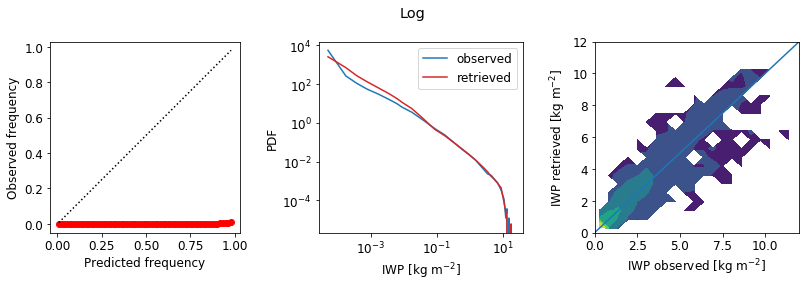

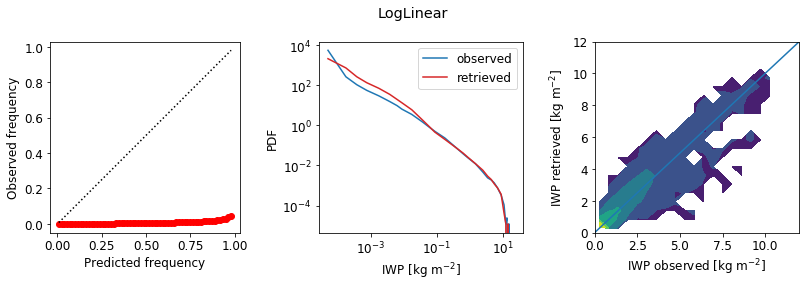

In [35]:

inputs           = np.array( ["ta", "t2m",  "wvp", "lat", "z0", "stype"])

#inputs           = np.array( ["ta", "t2m",  "wvp", "z0", "stype"])
qrnn_file        = os.path.expanduser("~/Dendrite/Projects/IWP/GMI/training_data/try_training/qrnn_gmi_he.nc")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = [12, 4])
fig.tight_layout(pad = 3.0)
fig.suptitle("Log")
y, y_pre, y_mean = get_retrieval(inputs, qrnn_file, ax1, ax2, ax3, log = True)

inputs           = np.array( ["ta", "t2m",  "wvp", "lat", "z0", "stype"])
qrnn_file        = os.path.expanduser("~/Dendrite/Projects/IWP/GMI/training_data/try_training/qrnn_gmi_he_loglinear.nc")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = [12, 4])
fig.tight_layout(pad = 3.0)
fig.suptitle("LogLinear")
y, y_pre, y_mean = get_retrieval(inputs, qrnn_file, ax1, ax2, ax3, log = False)

fig.savefig("comparison_log_loglinear_testdata.png")

16.318773439906714

/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


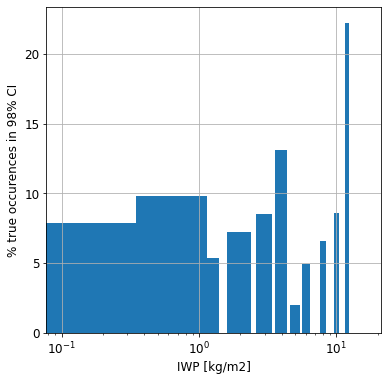

In [22]:
ntrue, counts, logbins = plot_sharpness(y, y_pre)
fig, ax = plt.subplots(1, 1, figsize = [6, 6])
ax.bar(logbins[:len(counts)], 100 * ntrue[:len(counts)]/counts)
#ax.plot(logbins[:len(counts2)], 100 * ntrue2[:len(counts2)]/counts2, '-o', label = "log")
#ax.plot(logbins[:len(counts3)], 100 * ntrue3[:len(counts3)]/counts3, '-o', label = "linear")

ax.set_xscale("log")
ax.set_xlabel("IWP [kg/m2]")
ax.set_ylabel("% true occurences in 98% CI")
ax.grid('on')
#ax.set_ylim([60, 100])

Text(0, 0.5, 'IWP')

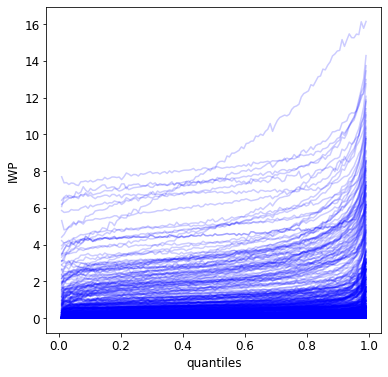

In [27]:
fig, ax = plt.subplots(1, 1, figsize = [6, 6])
rndinds = np.random.randint(1, 82000, 4000)
for i in rndinds:
    ax.plot(quantiles, y_pre[i, :], 'b', alpha = 0.2)
ax.set_xlabel("quantiles")
ax.set_ylabel("IWP")
#fig.savefig("quantiles.png")

/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


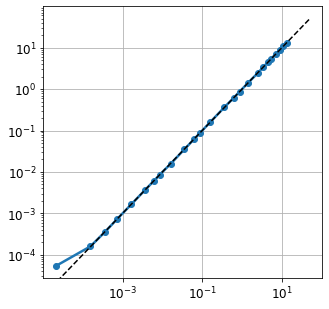

In [28]:
bins = np.array([0.0,.0001,.00025,.0005, 0.001,.0025,.005,
                 0.0075, 0.01, 0.025, 0.05, 0.075, .1, .25,
                 .5, .75, 1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 28, 32, 50])

#bins = np.logspace(np.log10(0.001), np.log10(25), 500)
iy = np.digitize((y), bins)
iyp = np.digitize((y_mean), bins)

iby = np.bincount(iy, minlength = len(bins), weights = y)
ibyp = np.bincount(iyp, minlength = len(bins), weights = y_mean)

niby = np.bincount(iy, minlength = len(bins))
nibyp = np.bincount(iyp, minlength = len(bins))

fig, ax = plt.subplots(1, 1, figsize = [5, 5])
ax.plot(iby/niby, ibyp/nibyp, 'o-', linewidth = 2.5)

ax.set_yscale("log")
ax.set_xscale("log")
ax.grid("on")
xx = bins
yy = bins

ax.plot(xx, yy, 'k--')

In [36]:
def plot_iwp(lat, lon, iwp0, iwp, iwp1, tb, mask):
    
    fig, ax = plt.subplots(1, 3, figsize = [15, 8])
    fig.tight_layout(pad=3.0)
    ax = ax.ravel()
    diff = 100 * (np.exp(np.abs(np.log(iwp/iwp0))) - 1)
    
    bbox = [np.min(lon),np.min(lat),np.max(lon),np.max(lat)] # set bounds for plotting
    n_add = 0
    m = Basemap(llcrnrlon=bbox[0]-n_add,llcrnrlat=bbox[1]-n_add,
                urcrnrlon=bbox[2]+n_add,urcrnrlat=bbox[3]+n_add,resolution='l',
                projection='cyl')
    x, y = m(lon, lat)    
    for var, axes, t in zip([iwp0, iwp, iwp1], ax, ["Simulated", " y_median", "y_mean"]):
        
        cs = axes.scatter(lon[mask],lat[mask], c = var[mask]* 1000,
                          norm=colors.LogNorm(), vmin = 1, vmax = 10000,)
                        # cmap = cm.Paired)
            
        #cs = m.scatter(lon, lat, var[mask]* 1000, ax = axes)    
        axes.set_title(t)
        ax[0].set_ylabel("Latitude [deg]")
        #axes.set_xlabel("Longitude [deg]")
    cbar = fig.colorbar(cs, ax=[ax[0], ax[1], ax[2]])
    cbar.ax.set_ylabel("IWP [g/m2]") 

def get_mask(lat, lon, latlims, lonlims):
    
    im  = (lat >= latlims[0]) & (lat <= latlims[1])
    im1 = (lon >=  lonlims[0]) & (lon < lonlims[1])
    mask  = np.logical_and(im, im1)
    
    return mask    

def get_coords(validation_data):
    lat = validation_data.lat
    lon = validation_data.lon%360
    tb  = validation_data.x[:, :5]
    stype = validation_data.x[:, -2]

    
    return lat, lon, tb, stype

### spatial analysis IWP

In [37]:
lat1,  lon1, tb1, stype1    = get_coords(validation_data)
lonlims = [20, 30]
latlims = [0, 30]
mask1 = get_mask(lat1, lon1, latlims, lonlims)
plot_iwp(lat1, lon1, y1, y_pre1[:, imedian], y_pos_mean1, tb1, mask1)  

lonlims = [0, 360]
latlims = [-60, 60]
mask1 = get_mask(lat1, lon1, latlims, lonlims)
plot_iwp(lat1, lon1, y1, y_pre1[:, imedian], y_pos_mean1, tb1, mask1)  

NameError: name 'validation_data' is not defined

### compare histograms of y0 - y_pre

NameError: name 'y1' is not defined

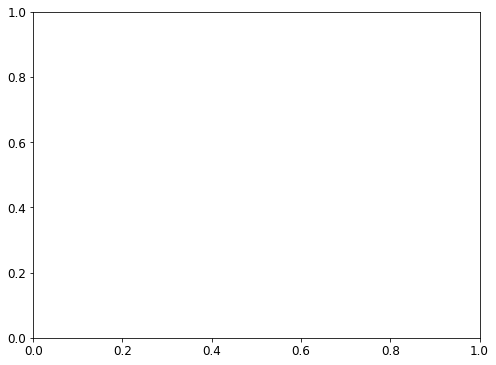

In [38]:
bins = np.arange(-2.5, 2.5, 0.05)
fig, ax = plt.subplots(1, 1, figsize = [8, 6])
hist_median, _ = np.histogram(y1 - y_pre1[:, imedian], bins, density = True)
hist_mean, _   = np.histogram(y1 - y_pos_mean1 , bins, density = True)
xbins = (bins[1:] + bins[:-1])/2.
ax.plot(xbins, hist_median, label = "y_median")
ax.plot(xbins, hist_mean, label = "y_mean")
ax.set_yscale('log')
ax.legend()
ax.set_xlabel("y0 - y_pre [kg m$^{-2}$]")
ax.set_ylabel("PDF")
plt.grid(True)
plt.show()
fig.savefig("PDF_IWP.png", bbox_inches = "tight")

###  associated  uncertainty

In [ ]:

fig, ax = plt.subplots(1, 1, figsize = [6, 6])
rndinds = np.random.randint(1, 30000, 1500)
for i in rndinds:
    ax.plot(quantiles, y_pre1[i, :], 'b', alpha = 0.2)
ax.set_xlabel("quantiles")
ax.set_ylabel("IWP")
fig.savefig("quantiles.png")

In [ ]:
y1.shape

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = [8, 8])
fig.tight_layout(pad=3.0)

for ax, ix, title in zip(axes.ravel(), [0, 1, 2, 3], ["water", "land", "snow", "sea-ice"]):
    mask = stype1 == ix
    ax.scatter(y1[mask], y_pos_mean1[mask])
    ax.set_title(title)
    ax.set_ylabel("Retrieved")
    ax.set_xlabel("Simulated") 

#### 2d histogram y0 and y_pre on log scales (see ISMAR article for reference)

In [ ]:
im = stype1 == 0
im1 = stype1 == 2
xyrange = [[-5, 2], [-5, 20]]
#xyrange = [[1e-5, 1e2], [1e-5, 1e20]]
bins = [50, 120]
xdat1 =  (np.log10(y_pos_mean1))
ydat1 = (np.log10((y_pos_mean1/y1)))

xdat = (np.log10(y_pre1[:, imedian]))
ydat = (np.log10((y_pre1[:, imedian]/y1)))


fig, axes = plt.subplots(1, 2, figsize = [12, 6])
fig.tight_layout(pad=3.0)    
for ax, xdt, ydt, title in zip(axes.ravel(), [xdat, xdat1], [ydat, ydat1], ["median", "mean"]):
        
        hh, xyrange, xdt1, ydt1 = hist2d(xdt, ydt, 
                                           bins = bins, xyrange = xyrange)
        cs = ax.contourf(np.flipud(hh.T), 
                         levels=[0.5e-3, 1e-3,  0.5e-2, 1e-2,  0.5e-1, 1e-1, 0.5,  1e0], 
                         cmap= 'Blues',
                extent=np.array(xyrange).flatten(), 
            locator= ticker.LogLocator(), origin='upper')
        
        
        hh, xyrange, xdt1, ydt1 = hist2d(xdt[im1], ydt[im1], 
                                           bins = bins, xyrange = xyrange)
        cs1 = ax.contour(np.flipud(hh.T), 
                         levels=[0.5e-3, 1e-3,  0.5e-2, 1e-2,  0.5e-1, 1e-1, 0.5,  1e0], 
                         cmap= 'Reds',
                extent=np.array(xyrange).flatten(), 
            locator= ticker.LogLocator(), origin='upper')
        
        
        

        hh, locx, locy = np.histogram2d(xdt, ydt, range = xyrange,
                                     bins = bins, density = True)
        dy = 0.5 * (locy[1:] + locy[:-1])
        dx = 0.5 * (locx[1:] + locx[:-1])
        off = []

        for i in range(50):
            a = np.sum(dy * hh[i, :])
            b = np.sum(hh[i, :])
            off.append(a/b)
        off = np.stack(off)    
        ax.plot(dx, off, 'k')
        ax.set_ylim([-5, 10])
        ax.grid('on')

        ax.set_ylabel(r"log10(y_pre / y0)]")
        ax.set_xlabel(r"log10(y_pre)")
        ax.set_title(title)
cbar = fig.colorbar(cs, ax = axes)  

fig.savefig("hist2d_IWP_hlats.png", bbox_inches = "tight")

### mean fractional error

In [ ]:
def mfe( y0, y):
    return np.median(10**(np.abs(np.log10(y/y0))) - 1) * 100

def calculate_mfe(y0, y):
    nbins = 60
    logbins = np.log10(np.logspace(np.log10(1e-4), np.log10(1e2), nbins))
    ibins = np.digitize(np.log10(y0), logbins)
    err = []
    for ix in range(nbins):

        ix = np.where(ibins == ix)[0]

        err.append(mfe(y0[ix], y[ix]))
    return err, logbins

In [ ]:
y_pre1[y_pre1<0] = 0
err, logbins  = calculate_mfe(y1, y_pos_mean1)
err1, _ = calculate_mfe(y1, y_pre1[:, imedian])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = [6, 6])
fig.tight_layout(pad=1.0)   


ax.plot(10 ** (logbins[1:]), err[1:], '-o', label = "mean")
ax.plot(10 **(logbins[1:]), err1[1:], '-o', label = "median")
ax.set_ylim([0, 1000])
ax.set_xscale("log")
#ax.set_title()
ax.set_xlabel(r" IWP [kg m$^{-2}$] ")
ax.set_ylabel("Median fractional error [%]")
ax.legend()   
ax.grid('on')
fig.savefig("median_fractional_error.png", bbox_inches = "tight")

### RMSE and BIAS over stypes

In [ ]:
def rmse(y, y0):
    return np.sqrt(np.mean((y - y0)**2))

def mae(y, y0):
    return np.mean(np.abs(y - y0))

def bias(y, y0):
    return np.mean(y - y0)

In [ ]:
stype1

In [ ]:
rms = []
rms1 = []

bs = []
bs1 = []
stypes = ["water", "land", "snow", "seaice", "coastlines"]
for ix in [0, 1, 2, 3, 4]:
    im = stype1 == ix
    im1 = y1 > 0.01
    im = np.logical_and(im, im1)
    rms.append(rmse(y_pre1[im, imedian], y1[im]))
    rms1.append(rmse(y_pos_mean1[im], y1[im]))
    
    bs.append(bias(y_pre1[im, imedian], y1[im]))
    bs1.append(bias(y_pos_mean1[im], y1[im]))

fig, axes = plt.subplots(2, 1, figsize = [12, 8])
x = np.arange(len(stypes))  # the label locations
width = .20  # the width of the bars
for ax, r, b in zip(axes.ravel(), [rms, bs], [rms1, bs1]):
    print(r)
    ax.bar(x - width/2, r, width = width, label = "median", color = "tab:blue")
    ax.bar(x + width/2, b, width = width, label = "mean", color = "tab:orange")
    ax.set_xticks(x)
    ax.set_xticklabels(stypes)
    ax.legend()
    ax.grid("on")
axes[0].set_ylabel(r"RMSE [kg m$^{-2}$]")
axes[1].set_ylabel(r"Bias [kg m$^{-2}$]")

fig.suptitle("statistics for IWP >= 0.01 kg/m2")
fig.savefig("RMSE_bias_hlats.png", bbox_inches = "tight")


In [ ]:
rms = []
rms1 = []

bs = []
bs1 = []
stypes = ["water", "land", "snow", "seaice", "coastlines"]
for ix in [0, 1, 2, 3, 4]:
    im = stype1 == ix
    #im1 = y1 > 0.01
    #im = np.logical_and(im, im1)
    rms.append(rmse(y_pre1[im, imedian], y1[im]))
    rms1.append(rmse(y_pos_mean1[im], y1[im]))
    
    bs.append(bias(y_pre1[im, imedian], y1[im]))
    bs1.append(bias(y_pos_mean1[im], y1[im]))

fig, axes = plt.subplots(2, 1, figsize = [12, 8])
x = np.arange(len(stypes))  # the label locations
width = .20  # the width of the bars
for ax, r, b in zip(axes.ravel(), [rms, bs], [rms1, bs1]):
    print(r)
    ax.bar(x - width/2, r, width = width, label = "median", color = "tab:blue")
    ax.bar(x + width/2, b, width = width, label = "mean", color = "tab:orange")
    ax.set_xticks(x)
    ax.set_xticklabels(stypes)
    ax.legend()
    ax.grid("on")
axes[0].set_ylabel(r"RMSE [kg m$^{-2}$]")
axes[1].set_ylabel(r"Bias [kg m$^{-2}$]")

fig.suptitle("statistics for all IWP")
fig.savefig("RMSE_bias_hlats_all.png", bbox_inches = "tight")

#### Error over IWP bins

In [ ]:
nbins = 50
logbins = np.logspace(np.log10(1e-3), np.log10(0.5e2), nbins)
ibins = np.digitize(y1, logbins)
counts = np.bincount(ibins)
ntrue = []
for j in range(nbins):
    itrue = ([i for i in range(y1.shape[0]) if y1[i] >= y_pre1[i, 0] if y1[i] <= y_pre1[i, -1] if ibins[i] == j])
    ntrue.append(len(itrue))
ntrue = np.array(ntrue)

fig, ax = plt.subplots(1, 1, figsize = [6, 6])
ax.plot(logbins[:len(counts)], 100 * ntrue[:len(counts)]/counts, '-o')
ax.set_xscale("log")
ax.set_xlabel("IWP [kg/m2]")
ax.set_ylabel("% true occurences in 98% CI")
ax.grid('on')
ax.set_ylim([0, 100])
fig.savefig("Uncertainty_IWP.png", bbox_inches = "tight") 
    

In [ ]:
nbins = 50
logbins = np.logspace(np.log10(1e-8), np.log10(0.5e2), nbins)
ibins = np.digitize(y1, logbins)
imatrix = np.zeros([nbins, nbins])
ibins_p = np.digitize(y_pos_mean1, logbins)


for i in range(ibins.max()):
    in2 = ibins_p[ibins == i].max()
    ib = np.bincount(ibins_p[ibins == i])
    imatrix[ :in2 + 1, i] = 100 * ib/np.sum(ibins == 1)
    
fig, ax = plt.subplots(1, 1, figsize = [7, 6])
imatrix[imatrix == 0] = np.nan
cs = ax.pcolormesh(logbins, logbins, imatrix, cmap='Blues', vmin = 0, vmax = 50)
ax.set_yscale('log')
ax.set_xscale('log')
x = logbins
y = x
ax.plot(x, y, alpha = 0.1)
fig.colorbar(cs)
ax.set_xlabel("IWP simulated [kg/m2]")
ax.set_ylabel("IWP retrieved [kg/m2]")
ax.set_xlim(1e-8, 50)
ax.set_ylim(1e-8, 50)
fig.savefig("histogram2d_IWP.png", bbox_inches = "tight")


### check false hits/misses

In [ ]:
iwplim = 0.01 #[kg/m2]

falsemiss = y1[y_pos_mean1 <= iwplim] >= iwplim

falsehits = y_pos_mean1[y1 <= iwplim] >= iwplim

print("falsemiss among total data : ", np.sum(falsemiss)/y1.shape[0], "\n",
      "falsehits among total data : ", np.sum(falsehits)/y1.shape[0])


print("falsemiss among IWP < 0.01 kg/m2 : ", np.sum(falsemiss)/np.sum(y1[y_pos_mean1 <= iwplim]), "\n",
      "falsehits among IWP < 0.01 kg/m2 : ", np.sum(falsehits)/np.sum(y_pos_mean1[y1 <= iwplim]))



In [ ]:
y_pos_mean1.min()


In [ ]:
logbins

In [ ]:
outfile1 = "qrnn_gmi_all_z0_log10.pickle"
outfile2 = "qrnn_gmi_all_z0.pickle"
outfile3 = "qrnn_gmi_all_z0_linear.pickle"

In [ ]:
def read_pickle(file):
    with open(file, "rb") as f:
        y      = pickle.load(f)
        y_pre  = pickle.load(f)
        y_mean = pickle.load(f)
        f.close()
        
    return y, y_pre, y_mean

y1, y_pre1, y_mean1  = read_pickle(outfile1)
y2, y_pre2, y_mean2  = read_pickle(outfile2)
y3, y_pre3, y_mean3  = read_pickle(outfile3)
    

In [ ]:
def stats(y1, y_pre1, y_pos_mean1):
    rms = []
    rms1 = []

    bs = []
    bs1 = []
    stypes = ["water", "land", "snow", "seaice", "coastlines"]
    for ix in [0, 1, 2, 3, 4]:
        im = stype1 == ix
        #im1 = y1 > 0.01
        #im = np.logical_and(im, im1)
        rms.append(rmse(y_pre1[im, imedian], y1[im]))
        rms1.append(rmse(y_pos_mean1[im], y1[im]))

        bs.append(bias(y_pre1[im, imedian], y1[im]))
        bs1.append(bias(y_pos_mean1[im], y1[im]))
        
    return rms, bs   

In [ ]:
stypes = ["water", "land", "snow", "seaice", "coastlines"]
rms1, bs1 = stats(y1, y_pre1, y_mean1)
rms2, bs2 = stats(y2, y_pre2, y_mean2)
rms3, bs3 = stats(y3, y_pre3, y_mean3)

In [ ]:
x = np.arange(0, len(stypes), 1)
width = 0.15
fig, ax = plt.subplots(1, 1, figsize = [10, 6])
ax.bar(x - 0.2, rms1, width,  label = "log10")
ax.bar(x , rms2, width, label = "log")
ax.bar(x + 0.2, rms3, width, label = "linear")
ax.set_xticks(x)
ax.set_xticklabels(stypes)
ax.legend()


In [ ]:
x = np.arange(0, len(stypes), 1)
width = 0.15
fig, ax = plt.subplots(1, 1, figsize = [10, 6])
ax.bar(x - 0.2, bs1, width,  label = "log10")
ax.bar(x , bs2, width, label = "log")
ax.bar(x + 0.2, bs3, width, label = "linear")
ax.set_xticks(x)
ax.set_xticklabels(stypes)
ax.legend()

In [ ]:
err1, logbins  = calculate_mfe(y1, y_mean1)
err2, _        = calculate_mfe(y2, y_mean2)
err3, _        = calculate_mfe(y3, y_mean3)

fig, ax = plt.subplots(1, 1, figsize = [6, 6])
fig.tight_layout(pad=1.0)   


ax.plot(10 ** (logbins[1:]), err1[1:], '-o', label = "log10")
ax.plot(10 **(logbins[1:]), err2[1:], '-o', label = "log")
ax.plot(10 **(logbins[1:]), err3[1:], '-o', label = "linear")
ax.set_ylim([0, 1000])
ax.set_xscale("log")
#ax.set_title()
ax.set_xlabel(r" IWP [kg m$^{-2}$] ")
ax.set_ylabel("Median fractional error [%]")
ax.legend()   
ax.grid('on')
fig.savefig("median_fractional_error.png", bbox_inches = "tight")

In [ ]:
def true_events(y1, y_pre1):
    nbins = 50
    logbins = np.logspace(np.log10(1e-3), np.log10(0.5e2), nbins)
    ibins = np.digitize(y1, logbins)
    counts = np.bincount(ibins)
    ntrue = []
    for j in range(nbins):
        itrue = ([i for i in range(y1.shape[0]) if y1[i] >= y_pre1[i, 0] if y1[i] <= y_pre1[i, -1] if ibins[i] == j])
        ntrue.append(len(itrue))
    ntrue = np.array(ntrue)
    
    return ntrue, counts, logbins


ntrue1, counts1, logbins = true_events(y1, y_pre1)
ntrue2, counts2, _ = true_events(y2, y_pre2)
ntrue3, counts3, _ = true_events(y3, y_pre3)


fig, ax = plt.subplots(1, 1, figsize = [6, 6])
ax.plot(logbins[:len(counts1)], 100 * ntrue1[:len(counts1)]/counts1, '-o', label = "log10")
ax.plot(logbins[:len(counts2)], 100 * ntrue2[:len(counts2)]/counts2, '-o', label = "log")
ax.plot(logbins[:len(counts3)], 100 * ntrue3[:len(counts3)]/counts3, '-o', label = "linear")

ax.set_xscale("log")
ax.set_xlabel("IWP [kg/m2]")
ax.set_ylabel("% true occurences in 98% CI")
ax.grid('on')
ax.set_ylim([60, 100])
ax.legend()
fig.savefig("Uncertainty_IWP.png", bbox_inches = "tight") 

In [ ]:
dataset.iwp